# Image recognition applied to Hearthstone cardsets

First, we need to scrape data from the Wikia Hearthstone website. We'll build a dataset containing the following information :
* Name of the card
* Set in which the card was released
* Type of the card (there are several types of card in Hearthstone : minions, spells, weapons)
* Class of the card (there are several of these as well : hunter, warlock, shaman, mage)
* Rarity (Scaling in this fashion : common, rare, epic, legendary)
* Cost (mana you need to pay to play the card)
* Attack (only for minions and weapons)
* Health (only for minions)
* Abilities
* Artist
* Text (explaining what the card actually does)
* Quote (a brief text that express some kind of personality of the card)
* Link to the image
* Subtype
* Shape of the image

Let's start by importing all the necessary packages.

In [54]:
import os
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup, element
import torch
from torchvision import datasets, transforms, utils, models
from torch.utils.data import DataLoader, dataset

## Defining main functions to scrape our data.

Then, we'll need to define a class that will handle our scraping job. It contains several functions :
* make_soup : just processes and parses the web page with BeautifulSoup
* convert_card_names : changes the name of the card so we can combine it to build its URL
* get_card_meta : gets all the metadata of a card
* get_meta_element : a helper function that is called in the previous one to handle different parsing operations
* get_card_text : another helper to parse the card web page
* get_img_link : finally, a function that retrives the card image URL

In [2]:
class Build_Card_Dataset:
    """Class that contains metadata scraped on https://hearthstone.gamepedia.com."""
 

    def __init__(self, card_name):
        
        self.base_url = "https://hearthstone.gamepedia.com"
        self.cards_url = "Category:Cards"
        self.card_name = card_name
        
        self.card_meta = {
            "Name": self.card_name,
            "Set": "",
            "Type": "",
            "Class": "Neutral",
            "Rarity": "",
            "Cost": 0,
            "Attack": "",
            "Health": "",
            "Abilities": [],
            "Artist": "",
            "Text": "",
            "Quote": "",
            "Img_link": ""
        }
        
    
    def make_card_soup(self):
        """Makes the soup from a specific card name."""
        
        r = requests.get(os.path.join(base_url, self.card_name))
        self.soup = BeautifulSoup(r.text, "lxml")
  

    def convert_card_name(self):
        """Converts card name into ready to process URL."""
        
        self.card_name = self.card_name.split()
        self.card_name = "_".join(self.card_name)
 

    def get_card_meta(self):
        """Gets a card's name and outputs its metadata."""
        
        # Get the meta table tag and build an iterator
        meta_table = self.soup.find("div", class_="body").table.tbody
        table_iter = meta_table.children
            
        try:
            for self.sib in table_iter:
                if type(self.sib) == element.Tag:
                    self.get_meta_element("Set")
                    self.get_meta_element("Type")
                    self.get_meta_element("Subtype")
                    self.get_meta_element("Class")
                    self.get_meta_element("Artist")
                    self.get_meta_element("Rarity")
                    self.get_meta_element("Cost")
                    self.get_meta_element("Attack")
                    self.get_meta_element("Health")
                    self.get_meta_element("Abilities")
        except AttributeError:
            print(f"Error : {self.card_name}")


    def get_meta_element(self, elem):
        """Checks which element in meta_table is called and adds it to card_meta dict."""
        
        try:
            if self.sib.th.b.get_text() == str(elem + ":"):
                if self.sib.th.b.get_text() == "Cost:":
                    self.card_meta[elem] = self.sib.td.get_text(strip=True)
                elif self.sib.th.b.get_text() == "Attack:":
                    self.card_meta[elem] = self.sib.td.get_text(strip=True)
                elif self.sib.th.b.get_text() == "Health:":
                    self.card_meta[elem] = self.sib.td.get_text(strip=True)
                elif self.sib.th.b.get_text() == "Abilities:":
                    for child in self.sib.td.children:
                        if type(child) == element.Tag:
                            self.card_meta[elem].append(child.get_text())
                else:
                    self.card_meta[elem] = self.sib.td.a.get_text()
        except AttributeError:
            pass
 

    def get_card_text(self):
        """Gets the card's text and quote."""
        
        side_panel = self.soup.find("div", class_="body").next_siblings
        
        for i, elem in enumerate(side_panel):
            try:
                if i == 1:
                    self.card_meta["Text"] = elem.get_text()
                elif i == 2:
                    self.card_meta["Quote"] = elem.get_text()
            except AttributeError:
                pass
            
            
    def get_img_link(self):
        """Gets the link of the image of the card."""
        
        img = self.soup.find("a", attrs={"class", "image"})
        self.card_meta["Img_link"] = img.contents[0]["src"]

Now, we need to define a function to get each card's name and some variables to store that data. We'll need to use our `Build_Card_Dataset`.

In [3]:
base_url = "https://hearthstone.gamepedia.com"
card_list = []
root_link = "https://hearthstone.gamepedia.com/Category:Cards"

We'll define a simple recursive function that gets a starting page and clicks on the "next page" button each time it scrapes it all. The function stop calling itself when it triggers the `TypeError` exception.

In [4]:
def scrape(root_link):

    r = requests.get(root_link)
    soup = BeautifulSoup(r.text, "lxml")
    cards = soup.find_all("a", attrs={"class": "to_hasTooltip"})
    
    regex = re.compile("next page")
    link = soup.find("a", text=regex)
    
    for card in cards:
        card_list.append(card.get_text())
    
    try:
        root_link = base_url + str(link["href"])
        scrape(root_link)
    except TypeError:
        print("Card scraping job done.")

In [5]:
scrape(root_link)

Card scraping job done.


Now that we have our functions, we can use them to scrape all the data we need to build a dataset that will help us later to associate our labels with the images.

## Scraping data.

We can use a simple loop to iterate over the card list we scraped earlier to build the dataset with our `Build_Card_Dataset` class. We pass exceptions on `AttributeError` because it concerns specific informations on the web page linked to heroes and other stuff we won't look at in our case.

Because we want to be nice to the servers, we'll scrape slowly by adding stops between each iteration `time.sleep(random.randint(1, 4)`. Because some servers might be annoying, even if we scrape slowly, we'll make random stops.

In [6]:
import time
import random

card_metadata_list = []

for i, card in enumerate(card_list):
    print(i, card)
    try:
        time.sleep(random.randint(1, 6))
        card = Build_Card_Dataset(card)
        card.make_card_soup()
        card.convert_card_name()
        card.get_card_meta()
        card.get_card_text()
        card.get_img_link()
        card_metadata_list.append(card.card_meta)
    except Exception as e:
        print(e)

0 "Little Friend"
1 A Light in the Darkness
2 A New Challenger...
3 Aberrant Berserker
4 Abominable Bowman
5 Abomination
6 Abusive Sergeant
7 Abyssal Destroyer
8 Abyssal Enforcer
9 Abyssal Summoner
10 Academic Espionage
11 Ace Hunter Kreen
12 Acherus Veteran
13 Acidic Swamp Ooze
14 Acidmaw
15 Acolyte of Agony
16 Acolyte of Pain
17 Acornbearer
18 Acrobatics
19 Activate the Obelisk
20 Adaptation
21 Addled Grizzly
22 Adorable Infestation
23 Aeon Reaver
24 Aeroponics
25 Air Elemental
26 Air Raid
27 Air Raid (Twinspell)
28 Akali, the Rhino
29 Akama
30 Akama Prime
31 Al'Akir the Windlord
32 Al'ar
33 Alarm-o-Bot
34 Albatross
35 Alda Petrik
36 Aldor Attendant
37 Aldor Peacekeeper
38 Aldor Truthseeker
39 Aldrachi Warblades
40 Alexstrasza
41 Alexstrasza's Champion
42 Alleria Windrunner
'NoneType' object has no attribute 'tbody'
43 Alley Armorsmith
44 Alleycat
45 Alterac Thrall
'NoneType' object has no attribute 'tbody'
46 Altruis the Outcast
47 Aluneth
48 Am'gam Rager
49 Amalgam
50 Amani Berserk

Now that we have all our metadata, we can export that information to a CSV file that we will use later on.

In [7]:
df = pd.DataFrame(card_metadata_list)
df.to_csv("hs_card_dataset.csv", sep=";", encoding="utf-8")

## Downloading images.

The next step is to download every cards image. This is pretty easy, we will use a simple function and make several directories that will match our need later. Those directories will match the type of the card we want to predict with our model.

In [10]:
from PIL import Image
from io import BytesIO

def download_img(img_link, file_name):
    
    r = requests.get(img_link)
    img = Image.open(BytesIO(r.content))
    img.save(file_name)

Now that we have all cards' metadata, we can scrape the website again to download every card's illustration.

In [23]:
import random
import time

for row in df.iterrows():
    
    # Checking if image is already downloaded
    if row[1]["Name"].replace("/", "_") + ".png" in os.listdir(os.path.join("data", str(row[1]["Subtype"]))):
        pass
    else:
        path = os.path.join("data", str(row[1]["Subtype"]), str(row[1]["Name"].replace("/", "_") + ".png"))
        print(path)
        try:
            time.sleep(random.randint(1, 4))
            download_img(row[1]["Img_link"], path)
        except FileNotFoundError:
            os.makedirs(os.path.join("data", str(row[1]["Subtype"])))

data/nan/Shan'do Wildclaw.png
data/nan/Shardshatter Mystic.png
data/nan/Shield of Honor.png
data/nan/Shifty Sophomore.png
data/Demon/Shima.png
data/nan/Showstopper.png
data/nan/Silas Darkmoon.png
data/nan/Smug Senior.png
data/nan/Snack Run.png
data/Demon/Snarling Vilefiend.png
data/nan/Sneaky Delinquent.png
data/nan/Solar Eclipse.png
data/nan/Sorcerous Substitute.png
data/nan/Soul Fragment.png
data/nan/Soul Shear.png
data/nan/Soulciologist Malicia.png
data/Demon/Soulfed Felhound.png
data/nan/Soulshard Lapidary.png
data/nan/Speaker Gidra.png
data/nan/Spectral Delinquent.png
data/Murloc/Spectral Flyer.png
data/nan/Spectral Senior.png
data/nan/Sphere of Sapience.png
data/Demon/Spirit Jailer.png
data/nan/Stage Dive.png
data/nan/Stage Dive (Corrupted).png
data/Mech/Stage Hand.png
data/nan/Star Student Stelina.png
data/nan/Steeldancer.png
data/Elemental/Steward of Scrolls.png
data/nan/Stiltstepper.png
data/nan/Stormstrike.png
data/nan/Strongman.png
data/nan/Strongman (Corrupted).png
data/Ele

## Some EDA.

First, let's count the number of minions in our dataset.

In [24]:
df = pd.read_csv("hs_sub.csv", sep=";")
df.drop(columns=["Unnamed: 0"], inplace=True)

In [26]:
minions = df[df["Type"] == "Minion"]
minions.head(2)

,Name,Set,Type,Class,Rarity,Cost,Attack,Health,Abilities,Artist,Text,Quote,Img_link,Subtype
0,"""Little Friend""",Mean Streets of Gadgetzan,Minion,Neutral,NaN,6,6.0,6.0,[],A.J. Nazzaro,See this card on Hearthpwn,[data page],https://gamepedia.cursecdn.com/hearthstone_gam...,NaN
3,Aberrant Berserker,Whispers of the Old Gods,Minion,Neutral,Common,4,3.0,5.0,"['Enrage', 'Increment attribute']",Jim Nelson,Has +2 Attack while damaged.,"I berserk, therefore I am.",https://gamepedia.cursecdn.com/hearthstone_gam...,NaN


Then, we count the number of spells.

In [27]:
spells = df[df["Type"] == "Spell"]
spells.head(2)

,Name,Set,Type,Class,Rarity,Cost,Attack,Health,Abilities,Artist,Text,Quote,Img_link,Subtype
1,A Light in the Darkness,Whispers of the Old Gods,Spell,Paladin,Common,2,NaN,NaN,"['Discover', 'Increment attribute']",Zoltan Boros,Discover a minion. Give it +1/+1.,"Wait, how can you have a light in the dark? If...",https://gamepedia.cursecdn.com/hearthstone_gam...,NaN
2,A New Challenger...,Rastakhan's Rumble,Spell,Paladin,Epic,7,NaN,NaN,"['Discover', 'Summon']",James Ryman,Discover a 6-Cost minion. Summon it with Taunt...,… Arrives? Approaches? TELL US ALREADY!,https://gamepedia.cursecdn.com/hearthstone_gam...,NaN


In [28]:
weapons = df[df["Type"] == "Weapon"]
weapons.head(2)

,Name,Set,Type,Class,Rarity,Cost,Attack,Health,Abilities,Artist,Text,Quote,Img_link,Subtype
36,Aldrachi Warblades,Basic,Weapon,Demon Hunter,NaN,3,2.0,NaN,['Lifesteal'],J. Axer,Lifesteal,The ancient Aldrachi were the greatest warrior...,https://gamepedia.cursecdn.com/hearthstone_gam...,NaN
43,Aluneth,Kobolds and Catacombs,Weapon,Mage,Legendary,6,0.0,NaN,['Draw cards'],Izzy Hoover,"At the end of your turn, draw 3 cards.",PHENOMENAL ARCANE POWER…itty bitty living space.,https://gamepedia.cursecdn.com/hearthstone_gam...,NaN


Now, let's visualize how many card of each type we have in our dataset.

<BarContainer object of 1 artists>

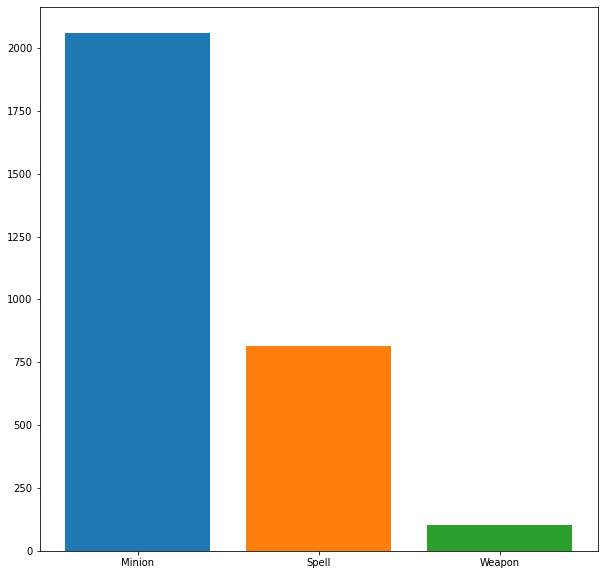

In [29]:
plt.figure(figsize=(10, 10))
plt.xticks(np.arange(1, 4), [minions["Type"].iloc[0], spells["Type"].iloc[0], weapons["Type"].iloc[0]])
plt.bar(1, len(minions))
plt.bar(2, len(spells))
plt.bar(3, len(weapons))

Just for fun, we can check the artists that draw the most card in Hearthstone.

In [30]:
artists = df["Artist"].value_counts()

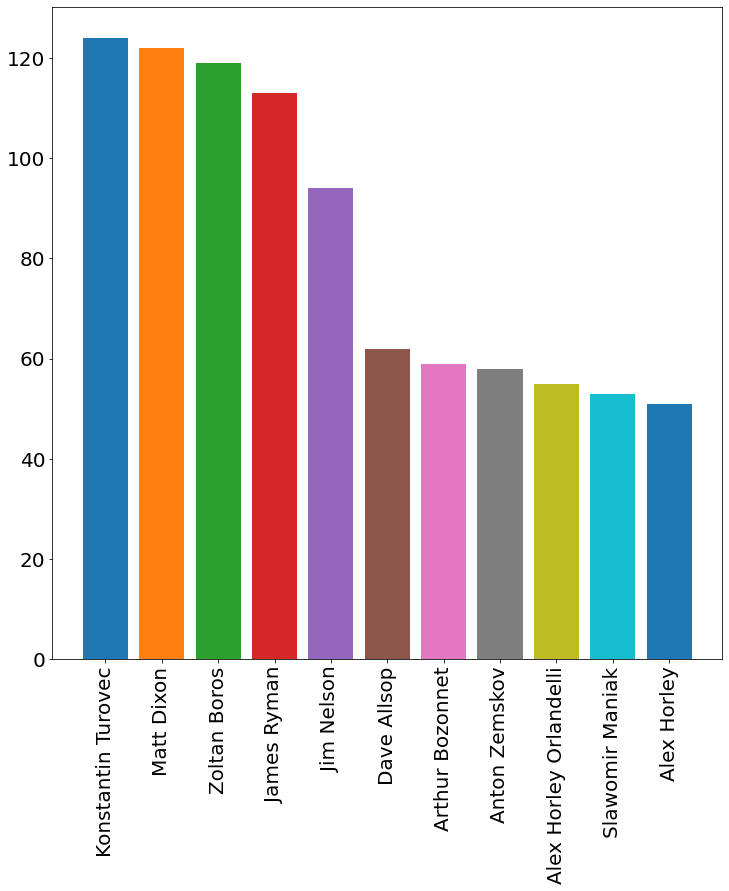

In [31]:
import numpy as np
import matplotlib.pyplot as plt

ind = np.arange(len(artists))
plt.figure(figsize=(12, 12))
plt.xticks(ind, artists.index, fontsize=20, rotation=90)
plt.yticks(fontsize=20)

for index, (count, artist) in enumerate(zip(artists, artists.index)):
    
    if count > 50:
        plt.bar(index, count)
    else:
        pass
    
plt.show()

## Let's get into serious business.

Now that we have our data and images, we want to build a model that can learn specific patterns.

In [4]:
df = pd.read_csv("hs_card_dataset.csv", sep=";")

### Checking image size.

Because some images are taken from other game modes (Battelground for example), we want to clean our dataset and select images that are of the same size. This is needed because PyTorch requires that our tensors have the same shape.

In [12]:
!pip install opencv-python
import cv2
import os

     |████████████████████████████████| 52.4 MB 20.2 MB/s eta 0:00:01     |███████████▏                    | 18.2 MB 10.1 MB/s eta 0:00:04


In [15]:
os.chdir("/Users/romainmularczyk/Desktop/Sciences Po/Doctorat/Sandbox/hearthstone_classifier/hs_classifier")
cur_path = os.getcwd()
cur_path = cur_path + "/data"

In [17]:
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head(2)

,Name,Set,Type,Class,Rarity,Cost,Attack,Health,Abilities,Artist,Text,Quote,Img_link,Subtype
0,"""Little Friend""",Mean Streets of Gadgetzan,Minion,Neutral,NaN,6,6.0,6,[],A.J. Nazzaro,See this card on Hearthpwn,[data page],https://static.wikia.nocookie.net/hearthstone_...,NaN
1,A Light in the Darkness,Whispers of the Old Gods,Spell,Paladin,Common,2,NaN,NaN,"['Discover', 'Increment attribute']",Zoltan Boros,Discover a minion. Give it +1/+1.,"Wait, how can you have a light in the dark? If...",https://static.wikia.nocookie.net/hearthstone_...,NaN


First, let's build a dataset that contains only minions.

In [18]:
minions = df[df["Type"] == "Minion"]
minions.head()

,Name,Set,Type,Class,Rarity,Cost,Attack,Health,Abilities,Artist,Text,Quote,Img_link,Subtype
0,"""Little Friend""",Mean Streets of Gadgetzan,Minion,Neutral,NaN,6,6.0,6,[],A.J. Nazzaro,See this card on Hearthpwn,[data page],https://static.wikia.nocookie.net/hearthstone_...,NaN
3,Aberrant Berserker,Whispers of the Old Gods,Minion,Neutral,Common,4,3.0,5,"['Enrage', 'Increment attribute']",Jim Nelson,Has +2 Attack while damaged.,"I berserk, therefore I am.",https://static.wikia.nocookie.net/hearthstone_...,NaN
4,Abominable Bowman,Knights of the Frozen Throne,Minion,Hunter,Epic,7,6.0,7,"['Deathrattle', 'Summon']",L. Lullabi & K. Turovec,Deathrattle: Summon a random friendly Beast th...,Frosty the Bowman... was an angry hateful soul...,https://static.wikia.nocookie.net/hearthstone_...,NaN
5,Abomination,Classic,Minion,Neutral,Rare,5,4.0,4,"['Deal damage', 'Deathrattle', 'Taunt']",Alex Horley Orlandelli,Taunt. Deathrattle: Deal 2 damage to ALL chara...,Abominations enjoy Fresh Meat and long walks o...,https://static.wikia.nocookie.net/hearthstone_...,NaN
6,Abusive Sergeant,Classic,Minion,Neutral,Common,1,1.0,1,"['Battlecry', 'Increment attribute']",Luca Zontini,Battlecry: Give a minion +2 Attack this turn.,"ADD ME TO YOUR DECK, MAGGOT!",https://static.wikia.nocookie.net/hearthstone_...,NaN


Now, let's build a list that contains all our minions' name.

In [23]:
# A list with all minion names
minions_name = [name[1]["Name"] for name in minions.iterrows()]

In [24]:
bad_size = []

for folder in os.listdir(cur_path):
    
    if folder == ".DS_Store":
        pass
    else:
        for file in os.listdir(cur_path + "/" + folder):
            if file == ".DS_Store":
                pass
            else:
                im = cv2.imread(cur_path + "/" + folder + "/" + file)
                if im.shape == (276, 200, 3):
                    pass
                else:
                    # Remove file extension in its name
                    bad_size.append((file[:-4], im.shape))

In [25]:
len(bad_size)

25

Now that we have a list containing all the card images that are not in the standard size, we can remove them from the dataset.

## Add image sizes to dataset for further uses.

Let's first open our dataset and clean it a bit more.

In [30]:
df = pd.read_csv("hs_card_dataset.csv", sep=";")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.set_index("Name", inplace=True)

In [31]:
# Replace name with ñ character in dataset
df.index = df.index.str.replace("ñ", "n")

Now we want to make sure every card has the exact same size. We build a list of tuples containing the name of the file and the shape of the associated image.

In [72]:
from PIL import Image

img_shp = []

for folder in os.listdir(cur_path):
    if folder == ".DS_Store":
        pass
    else:
        
        for file in os.listdir(os.path.join(cur_path, folder)):
            slash_file = file.replace("_", "/")
            path_to_file = os.path.join(cur_path, folder, file)
            # Check if file is in df
            if file[:-4] in df.index.tolist():
                img = cv2.imread(path_to_file)
                # Build a tuple containing name file and shape of image
                img_shp.append((file[:-4], img.shape))
                
                if img.shape != (276, 200, 3):
                    # Overwrite images
                    img = Image.open(path_to_file)
                    resized_img = img.resize((200, 276))
                    resized_img.save(path_to_file)
            else:
                # Quickly print out the none matching images so we make sure
                # we don't miss out anything, then we can remove them
                print(file)
                os.remove(path_to_file)

.DS_Store


Now let's check which of the cards don't have the same size.

In [73]:
to_reshape = []

for im, sh in img_shp:
    if sh != (276, 200, 3):
        print(im)
        print(sh)
        to_reshape.append(im)

Malygos's Sheep
(200, 276, 3)
Doom Rat
(200, 276, 3)
Shadowy
(200, 276, 3)
Call of the Wild
(200, 276, 3)
Crushing Walls
(200, 276, 3)
Demonbolt
(200, 276, 3)
Getaway Kodo
(200, 276, 3)
Grommash Hellscream
(200, 276, 3)
Kobold Illusionist
(200, 276, 3)
Muckling
(200, 276, 3)
Lesser Diamond Spellstone
(200, 276, 3)
Spiteful Smith
(200, 276, 3)
Tauren Warrior
(200, 276, 3)
Onyx Spellstone
(200, 276, 3)
Ruby Spellstone
(200, 276, 3)
Dragon's Hoard
(200, 276, 3)
Surrender to Madness
(200, 276, 3)
Dragoncaller Alanna
(200, 276, 3)
Sand Drudge
(200, 276, 3)
Weapons Project
(200, 276, 3)
Greater Onyx Spellstone
(200, 276, 3)
Spirit of the Raptor
(200, 276, 3)
Sergeant Sally
(200, 276, 3)
Greasefire Elemental
(200, 276, 3)
Hoarding Dragon
(200, 276, 3)


In [74]:
img_shp.sort()
len(img_shp)

3402

Let's build a list in which we select only the images with matching size.

In [75]:
img = []
shp = []

for im, sh in img_shp:
    img.append(im)
    shp.append(sh)

Let's use that list to go through our dataframe and select only the corresponding names. We should get 3402 images.

In [76]:
len(df[df.index.isin(img)])

3402

Let's store that filtered dataset in a new variable.

In [77]:
filt_df = df[df.index.isin(img)]

Now let's select only minions with the good image size.

In [78]:
minions = filt_df[filt_df["Type"] == "Minion"]

## Splitting our dataset.

Now that we have started to build our dataset, we want to split it between minion subtypes to make different trials. This might be useful for further tests.

In [9]:
def split_data(path):
    
    sizes = {}
        
    for folder in os.listdir(path):
        
        if folder == ".DS_Store":
            pass
        else:
            sizes[folder] = len(os.listdir(os.path.join(path, folder)))
            
    return sizes

In [10]:
sizes = split_data(os.getcwd() + "/data")
sizes

{'Murloc': 56,
 'Beast': 301,
 'Pirate': 40,
 'nan': 2495,
 'All': 3,
 'Elemental': 131,
 'Dragon': 94,
 'Mech': 143,
 'Totem': 15,
 'Demon': 124}

We could try by working with beasts and mechs, for example. Then, we might try to work also with demons and elementals.

## Let's build a dataset.

From the CSV file we built, we need to select minions and build a new dataframe containing cards' names and their subptype.

In [32]:
cur_path = os.getcwd() + "/data"
cur_path

'/Users/romainmularczyk/Desktop/Sciences Po/Doctorat/Sandbox/hearthstone_classifier/hs_classifier/data'

In [33]:
ds = datasets.ImageFolder(cur_path, transform=transforms.ToTensor())

Let's try if it works.

In [34]:
ds[1]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

We can also take a look at all the classes.

In [35]:
ds.classes

['All',
 'Beast',
 'Demon',
 'Dragon',
 'Elemental',
 'Mech',
 'Murloc',
 'Pirate',
 'Totem',
 'nan']

Finally, let's check its length.

In [36]:
len(ds)

3402

## Build dataloaders and define first hyperparameters.

Let's define a standard batch size.

In [37]:
batch_size = 64

Let's make a function to visualize a specific item in the dataset.

In [38]:
import matplotlib.pyplot as plt

def show_ex(img, label):
    print("Label : ", ds.classes[label], str(label))
    plt.imshow(img.permute(1, 2, 0))

Label :  Beast 1


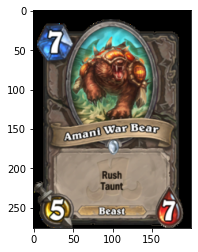

In [39]:
show_ex(*ds[8])

In [40]:
train_dl = DataLoader(ds, batch_size, shuffle=True)

### Validation dataset

Let's work with a validation set of size 14% of total length.

In [41]:
val_size = int(14/100 * len(ds))
val_size

476

In [42]:
train_size = len(ds) - val_size
train_size

2926

In [45]:
train_ds, val_ds = dataset.random_split(ds, [train_size, val_size])
(len(train_ds), len(val_ds))

(2926, 476)

### Build a function helper to visualize a batch.

We want to build a helper function that we can use to visualize batches of images.

In [46]:
import matplotlib.pyplot as plt

In [50]:
def show_batch(dataloader):
    for batch in dataloader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(utils.make_grid(batch[0], nrow=8).permute(1, 2, 0))
        break

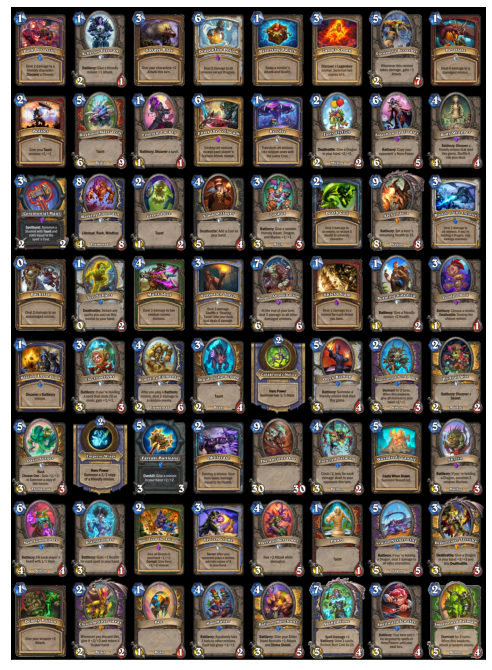

In [51]:
show_batch(train_dl)

## Loading our dataset to GPU.

Now we want to build a function that we can use to load data on a GPU for the training part.

In [52]:
def get_default_device():
    """Pick GPU if available, else CPU."""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device."""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device."""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device."""
        for batch in self.dl:
            yield to_device(batch, self.device)
            
    def __len__(self):
        """Number of batches."""
        return len(self.dl)

In [67]:
device = torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

## Defining residual blocks.

First, we want to define a residual block.

In [57]:
class SimpleResidualBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [58]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

NameError: name 'device' is not defined

## Define basic functions.

In [61]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(torch.nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = torch.F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Convolution blocks.

In [65]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              torch.nn.BatchNorm2d(out_channels), 
              torch.nn.ReLU(inplace=True)]
    if pool: layers.append(torch.nn.MaxPool2d(2))
    return torch.nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = torch.nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = torch.nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = torch.nn.Sequential(torch.nn.MaxPool2d(4), 
                                              torch.nn.Flatten(), 
                                              torch.nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [66]:
model = to_device(ResNet9(3, 10), device)
model

NameError: name 'device' is not defined

## Learning steps.

In [68]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [69]:
history = [evaluate(model, valid_dl)]
history

NameError: name 'model' is not defined

## Hyperparameters.

In [70]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam